## POS tagging using modified Viterbi

### Data Preparation

In [4]:
#Importing libraries
import nltk
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split

In [5]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

### Exploring The Data

Printing out first three sentences to check the tuples of words and their corresponding POS tags.

In [6]:
print(nltk_data[:3])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

Flattening out the sentences into tuple pairs of words and corresponding POS tags.

In [7]:
tagged_words = [tup for sent in nltk_data for tup in sent]
print("Length Of Tagged Words: ",len(tagged_words))
print("First few pairs: ",tagged_words[:4])

Length Of Tagged Words:  100676
First few pairs:  [('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM')]


Let's look at the unique words and the unique POS tags in the corpora.

In [8]:
def get_unique_words(tagged_words = tagged_words):
    """
    Generates unique words from given tagged tuples.
    
    @Author: Aryan Singh
    """
    words = [tup[0] for tup in tagged_words]
    unique_words = set(words)
    return unique_words

In [9]:
unique_words = get_unique_words()
print(len(unique_words))

12408


 Let's look at all the unique tags according to the corporus

In [10]:
def get_unique_tags(tagged_words = tagged_words):
    """
    Generates all unique tags from labelled tuples.
    
    @Author: Aryan Singh
    """
    tags = [tup[1] for tup in tagged_words]
    unique_tags = set(tags)
    return unique_tags

In [11]:
unique_tags = get_unique_tags()
print(unique_tags)

{'ADP', 'CONJ', '.', 'ADV', 'NUM', 'X', 'VERB', 'PRON', 'DET', 'NOUN', 'PRT', 'ADJ'}


Let's look at most frequent POS tags and words

In [13]:
from collections import Counter
tags = [tup[1] for tup in tagged_words]
tag_counts = Counter(tags)
tag_counts.most_common()

[('NOUN', 28867),
 ('VERB', 13564),
 ('.', 11715),
 ('ADP', 9857),
 ('DET', 8725),
 ('X', 6613),
 ('ADJ', 6397),
 ('NUM', 3546),
 ('PRT', 3219),
 ('ADV', 3171),
 ('PRON', 2737),
 ('CONJ', 2265)]

Let's define a method to find the most common tag assigned to a particular word.

In [14]:
def get_most_common_tag(word):
    """
    Get the most common tag for a word. For basic unigram POS tagger
    
    @Author Aryan Singh
    """
    tags = [tup[1] for tup in tagged_words if tup[0]==word]
    ct = Counter(tags).most_common(1)
    if not ct or ct==[]:
        return 'UNKNOWN'
    else:
        return ct[0][0]

In [15]:
get_most_common_tag('Pierre')

'NOUN'

In [16]:
def get_tags_word_end(tagged_words, ending, tag):
    """
    Method that takes in the ending and tag to find the
    percentage of words with that tag and that particular ending.
       
    @Author Aryan Singh
    """
    words_with_tag = [pair for pair in tagged_words if pair[1]==tag]
    end_pos = [pair for pair in words_with_tag if pair[0].endswith(ending)]
    return round((len(end_pos)*100.0/len(words_with_tag)),2)

Basic Analysis For Verbs

Check percentage of verbs ending with ed and ing.

In [17]:
get_tags_word_end(tagged_words,'ed','VERB')

20.69

In [18]:
get_tags_word_end(tagged_words,'ing','VERB')

10.85

**Check how many tags follow another tag**

In [19]:
def check_tag_followup(tags, tag1, tag2):
    """
    Method that checks percentage of instances where
    tag2 follows tag1 as compared to total number of occurences of tag1.
    
    @Author Aryan Singh
    """
    words_with_tag = [tag for tag in tags if tag==tag1]
    tags_t1_t2 = [(t, tags[i+1]) for i,t in enumerate(tags) if t==tag1 and tags[i+1]==tag2]
    return round((len(tags_t1_t2)*100.0/len(words_with_tag)),2)

Adjective followed by a noun

In [20]:
check_tag_followup(tags, 'ADJ', 'NOUN')

69.94

So adjective is followed by a noun is almost 70% of the cases. This can be a good rule to find POS tags for unknown words.

### Build the vanilla Viterbi based POS tagger

For the purpose of building a Viterbi heuristic and HMM based POS tagger First we need to calculate the **transmission probabilities(p(next tag/prev tag))** and **emission probabilities(p(word/tag))**. Then we can calculate the **p(tag/word) = emission prob * transmission prob**. In transmission prob. only the previous tag metters fue to the Markovian assumption.

### Split into train and test dataset

In [21]:
# Splitting into train and test
random.seed(1234)
train_set, test_set = train_test_split(nltk_data,test_size=0.05)

print(len(train_set))
print(len(test_set))
print(train_set[:3])

3718
196
[[('No', 'DET'), ('one', 'PRON'), ('speaks', 'VERB'), (',', '.'), ('and', 'CONJ'), ('the', 'DET'), ('snaking', 'VERB'), ('of', 'ADP'), ('the', 'DET'), ('ropes', 'NOUN'), ('seems', 'VERB'), ('*-1', 'X'), ('to', 'PRT'), ('make', 'VERB'), ('as', 'ADP'), ('much', 'ADJ'), ('sound', 'NOUN'), ('as', 'ADP'), ('the', 'DET'), ('bells', 'NOUN'), ('themselves', 'PRON'), ('*?*', 'X'), (',', '.'), ('*-2', 'X'), ('muffled', 'VERB'), ('*-3', 'X'), ('by', 'ADP'), ('the', 'DET'), ('ceiling', 'NOUN'), ('.', '.')], [('They', 'PRON'), ('fell', 'VERB'), ('into', 'ADP'), ('oblivion', 'NOUN'), ('after', 'ADP'), ('the', 'DET'), ('1929', 'NUM'), ('crash', 'NOUN'), ('.', '.')], [('It', 'PRON'), ('would', 'VERB'), ('contradict', 'VERB'), ('that', 'DET'), ('objective', 'NOUN'), ('if', 'ADP'), ('the', 'DET'), ('appropriations', 'NOUN'), ('clause', 'NOUN'), ('-LRB-', '.'), ('technically', 'ADV'), ('a', 'DET'), ('limitation', 'NOUN'), ('on', 'ADP'), ('legislative', 'ADJ'), ('power', 'NOUN'), ('-RRB-', '.'), 

In [22]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

95705

In [23]:
V = get_unique_words(tagged_words = train_tagged_words)
len(V)

12086

In [24]:
# number of tags
T = get_unique_tags(tagged_words = train_tagged_words)
len(T)

12

## Emission Probabilities

In [25]:
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [41]:
# compute word given tag: Emission Probability
tag_dict = {}
def word_given_tag(word, tag, train_bag = train_tagged_words):
    """
    Calculate emssion probability of a word given a tag.
    
    @Author Aryan Singh
    """
    tag_list = []
    if(tag in tag_dict):
        tag_list = tag_dict[tag]
    else:
        tag_list = [pair for pair in train_bag if pair[1]==tag]
        tag_dict[tag] = tag_list
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    return count_w_given_tag/count_tag

In [42]:
# Check for emission prob of large against Adjective
print(word_given_tag('large', 'ADJ'))

0.004445176160684887


In [43]:
# Check for an unknown word
print(word_given_tag('Android','NOUN')) 

0.0


## Transition Probabilities

In [125]:
def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    """
    Compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability
    
    @Author Aryan Singh
    """
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return count_t2_t1/count_t1

In [30]:
# Checking it once
print(t2_given_t1(t2='NOUN', t1='ADJ'))

0.6992097464603226


Check What percentage of tags appear at the start of sentences.

In [31]:
#Please note P(tag|start) is same as P(tag|'.')
print(t2_given_t1('NOUN', '.'))
print(t2_given_t1('VERB', '.'))
print(t2_given_t1('PRON', '.'))

0.22095528820254984
0.08843598491650206
0.06563117256239899


### Transition Probability Matrix

In [32]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)

In [34]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))
tags_df.head()

,CONJ,ADP,.,ADV,NUM,PRON,VERB,X,DET,NOUN,PRT,ADJ
CONJ,0.000464,0.051532,0.036676,0.055246,0.041783,0.058496,0.157846,0.008357,0.119777,0.349118,0.004178,0.116527
ADP,0.000748,0.016893,0.040308,0.013151,0.061478,0.069496,0.008019,0.034748,0.325457,0.321608,0.001390,0.106704
.,0.058179,0.090411,0.094092,0.053331,0.081792,0.065631,0.088436,0.027563,0.173011,0.220955,0.002334,0.044173
ADV,0.007280,0.120119,0.135341,0.079087,0.030113,0.015222,0.343812,0.023163,0.069821,0.031105,0.013567,0.131370
NUM,0.013777,0.035040,0.113208,0.002396,0.185385,0.001198,0.018568,0.215633,0.003294,0.353699,0.024558,0.033243


**Heat Map Of Frequent Tags**

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

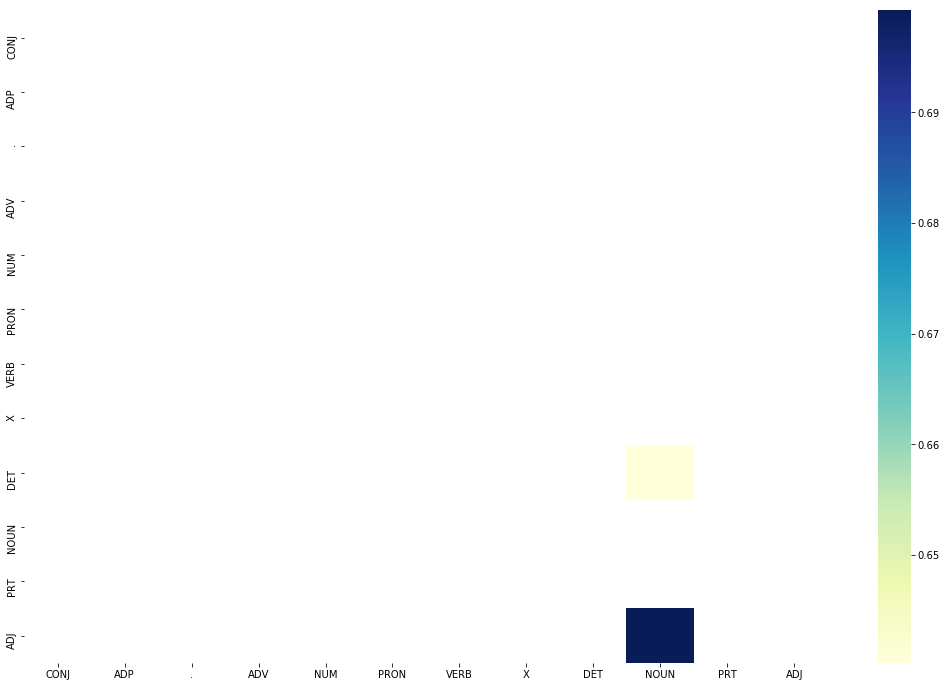

In [40]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent,cmap = 'YlGnBu')
plt.show()

**Vanilla Viterbi based HMM method**

In [60]:
# Vanilla Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    # training tags
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

### Solve the problem of unknown words

## Improving Vanilla Viterbi

### Approach 1: Considering transition probabilities as backoff for missing emission

In [74]:
# Vanilla Viterbi with transition as backoff for missing emissions
def Viterbi_transition_back(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    # training tags
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        trans = []
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            trans.append(transition_p)
        pmax = max(p)
        tmax = max(trans)
        # getting state for which probability is maximum
        if pmax != 0:       
            state_max = T[p.index(pmax)] 
            state.append(state_max)
        else:
            state_max = T[trans.index(tmax)] 
            state.append(state_max)            
    return list(zip(words, state))

### Approach 2: Considering lexicon and rule based tagger as backoff for missing emissions

In [72]:
regexp_tagger = nltk.RegexpTagger(
 [(r'^-?[0-9]+(.[0-9]+)?$', 'NUM'),   # cardinal numbers
  (r'(The|the|A|a|An|an)$', 'DET'),   # articles
  (r'.*able$', 'ADJ'),                # adjectives
  (r'.*ness$', 'NOUN'),               # nouns formed from adjectives
  (r'.*ly$', 'ADV'),                  # adverbs
  (r'.*s$', 'NOUN'),                  # plural nouns
  (r'.*ing$', 'VERB'),                # gerunds
  (r'.*ed$', 'VERB'),                 # past tense verbs
  (r'.*', 'NOUN')                     # nouns (default)
])
unigram_tagger = nltk.UnigramTagger(train_set,backoff=regexp_tagger)
bigram_tagger = nltk.BigramTagger(train_set, backoff=unigram_tagger) 

In [81]:
def lexical_rule_tagger(word, tagger = bigram_tagger):
    """
    Takes a word and retrieves the POS tag using rule based and regex
    based tagger.
    
    @Author: Aryan Singh
    """
    tag_tup = bigram_tagger.tag([word])
    return tag_tup[0][1]

In [70]:
# Vanilla Viterbi with lexical tagger as backoff
def Viterbi_lexical_rule_back(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    # training tags
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)
            state_probability = emission_p * transition_p    
            p.append(state_probability)
        pmax = max(p)
        # getting state for which probability is maximum
        if pmax != 0:       
            state_max = T[p.index(pmax)] 
            state.append(state_max)
        else:
            state.append(lexical_rule_tagger(word))            
    return list(zip(words, state))

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [65]:
actual_tagged_test = [tup for sent in test_set for tup in sent]
test_words = [tup[0] for tup in actual_tagged_test]

In [67]:
def get_tagging_accuracy(predicted_tagged_test, actual_tagged_test = actual_tagged_test):
    """
    Method to determine tagging accuracy given predicted tagset and actual one.
    
    @Author Aryan Singh
    """
    check = [i for i, j in zip(predicted_tagged_test, actual_tagged_test) if i == j]
    accuracy = len(check)/len(predicted_tagged_test)
    return accuracy

**Accuracy for Vanila Viterbi Algorithm**

In [68]:
predicted_tagged_test = Viterbi(test_words)
accuracy = get_tagging_accuracy(predicted_tagged_test)
print(accuracy)

0.9050492858579763


**Accuracy for Viterbi Heuristic HMM with transition probabilities as backup for missing Emission probabilities**

In [75]:
predicted_tagged_test = Viterbi_transition_back(test_words)
accuracy = get_tagging_accuracy(predicted_tagged_test)
print(accuracy)

0.935827801247234


**Accuracy for Viterbi Heuristic HMM with lexical and rule based tagger as backup for missing Emission probabilities**

In [83]:
predicted_tagged_test = Viterbi_lexical_rule_back(test_words)
accuracy = get_tagging_accuracy(predicted_tagged_test)
print(accuracy)

0.9509153087909877


### Compare the tagging accuracies on the test dataset

Let's read in the sentences containing a lot of unseen words and compare the tag prediction of the three approaches. Using intution and knowledge of english grammar to see which wrongly predicted POS tags got corrected as the approaches evolved.

In [103]:
import requests
path = 'http://aryancodify.tech/wp-content/uploads/2018/10/Test_sentences.txt'
f = requests.get(path)
sentences = f.content.splitlines()
sentences = map(lambda sen : sen.decode("utf-8"),sentences)
sentences = list(sentences)[:-3]
sentences

['Android is a mobile operating system developed by Google.',
 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.',
 "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.",
 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.',
 'Before entering politics, Donald Trump was a domineering businessman and a television personality.',
 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.',
 'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.',
 'Show me the cheapest round trips from Dallas to Atlanta',
 'I would like to see flights from Denver to Philadelphia.',
 'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.',
 'NASA invited social media users to experienc

Now that we have the sentences, let's get the individual tokens, that were not present in our training dataset and check the accuracy for respective words.

In [119]:
from nltk.tokenize import word_tokenize
token_lists = [word_tokenize(sentence) for sentence in sentences]
tokens = [words for token_list in token_lists for words in token_list]

In [120]:
unknown_tokens = [token for token in tokens if token not in V]
print(len(unknown_tokens))
unknown_tokens[:5]

36


['Android', 'Google', 'Android', 'OS', 'worldwide']

Now that we have unknown tokens let's see the predicted tags by the three approaches.

In [121]:
vanilla_tags = Viterbi(unknown_tokens)

In [122]:
vanilla_tags[:10]

[('Android', 'CONJ'),
 ('Google', 'CONJ'),
 ('Android', 'CONJ'),
 ('OS', 'CONJ'),
 ('worldwide', 'CONJ'),
 ('smartphones', 'CONJ'),
 ('2011', 'CONJ'),
 ('2013', 'CONJ'),
 ('Google', 'CONJ'),
 ('Twitter', 'CONJ')]

Vanilla tag is predicting everything as conjunction which is completely wrong. Lets look at Vanilla viterbi with transition probabailties as back off.

In [123]:
transition_viterbi_tags = Viterbi_transition_back(unknown_tokens)
transition_viterbi_tags

[('Android', 'NOUN'),
 ('Google', 'NOUN'),
 ('Android', 'NOUN'),
 ('OS', 'NOUN'),
 ('worldwide', 'NOUN'),
 ('smartphones', 'NOUN'),
 ('2011', 'NOUN'),
 ('2013', 'NOUN'),
 ('Google', 'NOUN'),
 ('Twitter', 'NOUN'),
 ('2015', 'NOUN'),
 ('Google', 'NOUN'),
 ('Twitter', 'NOUN'),
 ('firehose', 'NOUN'),
 ('Twitter', 'NOUN'),
 ('online', 'NOUN'),
 ('interact', 'NOUN'),
 ('messages', 'NOUN'),
 ('tweets', 'NOUN'),
 ('domineering', 'NOUN'),
 ('personality', 'NOUN'),
 ('2018', 'NOUN'),
 ('FIFA', 'NOUN'),
 ('Cup', 'NOUN'),
 ('21st', 'NOUN'),
 ('FIFA', 'NOUN'),
 ('Cup', 'NOUN'),
 ('tournament', 'NOUN'),
 ('contested', 'NOUN'),
 ('Cup', 'NOUN'),
 ('trips', 'NOUN'),
 ('arriving', 'NOUN'),
 ('NASA', 'NOUN'),
 ('invited', 'NOUN'),
 ('ICESAT-2', 'NOUN'),
 ('Satellite', 'NOUN')]

Transition viterbi is predicting everything as a noun which is better than the previous case but gives several wrong outputs like domineering is predicted as Noun, invited is also predicted as noun.

Now Let's try Viterbi with lexical and rule based back off.

In [124]:
lexical_viterbi_tags = Viterbi_lexical_rule_back(unknown_tokens)
lexical_viterbi_tags

[('Android', 'NOUN'),
 ('Google', 'NOUN'),
 ('Android', 'NOUN'),
 ('OS', 'NOUN'),
 ('worldwide', 'NOUN'),
 ('smartphones', 'NOUN'),
 ('2011', 'NUM'),
 ('2013', 'NUM'),
 ('Google', 'NOUN'),
 ('Twitter', 'NOUN'),
 ('2015', 'NUM'),
 ('Google', 'NOUN'),
 ('Twitter', 'NOUN'),
 ('firehose', 'NOUN'),
 ('Twitter', 'NOUN'),
 ('online', 'NOUN'),
 ('interact', 'NOUN'),
 ('messages', 'NOUN'),
 ('tweets', 'NOUN'),
 ('domineering', 'VERB'),
 ('personality', 'NOUN'),
 ('2018', 'NUM'),
 ('FIFA', 'NOUN'),
 ('Cup', 'NOUN'),
 ('21st', 'NOUN'),
 ('FIFA', 'NOUN'),
 ('Cup', 'NOUN'),
 ('tournament', 'NOUN'),
 ('contested', 'VERB'),
 ('Cup', 'NOUN'),
 ('trips', 'NOUN'),
 ('arriving', 'VERB'),
 ('NASA', 'NOUN'),
 ('invited', 'VERB'),
 ('ICESAT-2', 'NOUN'),
 ('Satellite', 'NOUN')]

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

1. contested: tagged as Noun earlier, corrected to VERB
2. 2018: tagged as Noun earlier, corrected to NUM
3. arriving: tagged as Noun earlier, corrected to VERB